In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# Data preporation

In [2]:
data = pd.read_csv("data/owid-covid-data.csv")
data["date"] = pd.to_datetime(data["date"])

In [3]:
train_start = pd.Timestamp(2020, 3, 3)
train_end = train_start + pd.Timedelta(days=50)
test_start = train_end + pd.Timedelta(days=1) 
test_end = pd.Timestamp(2020, 12, 31)

In [4]:
rus_data = data.loc[data["location"] == "Russia"].copy()
rus_data_2020 = rus_data.loc[data["date"] <= test_end]
dataset = rus_data_2020[rus_data_2020["date"] >= train_start]

columns_to_drop = list(set(dataset.columns) - set(["date", "new_cases", "total_cases"]))

dataset = dataset.drop(columns=columns_to_drop, axis=1).reset_index(drop=True)

cumsum = 0
for key, row in dataset.iterrows():
    if row.loc["new_cases"] == 0:
        cumsum += 1
        dataset.at[key, "new_cases"] = 1
    dataset.at[key, "total_cases"] += cumsum
    
    
dataset["log_new_cases"] = np.log(dataset["new_cases"])
dataset["log_total_cases"] = np.log(dataset["total_cases"])

train_data = dataset.loc[dataset["date"] < train_end]
test_data = dataset.loc[dataset["date"] >= test_start]

# Data analysis

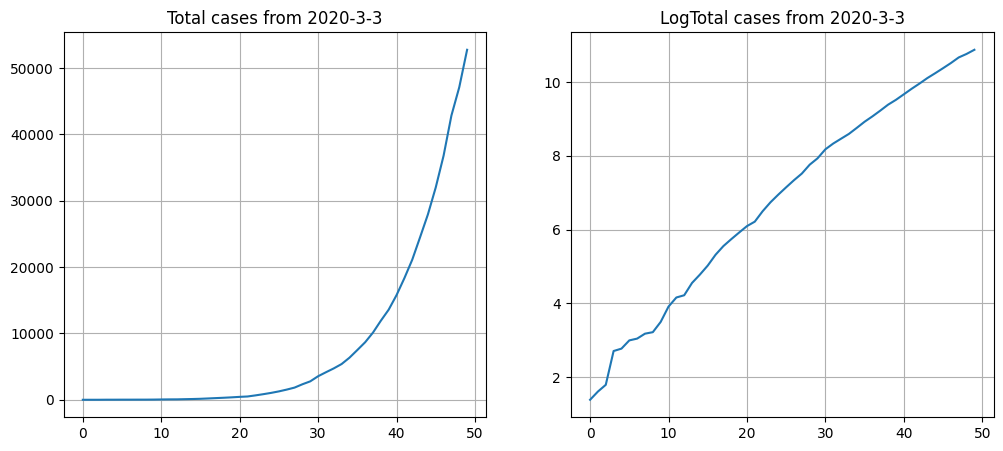

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(121)

plt.grid()
plt.plot(train_data.index, train_data["total_cases"])
plt.title("Total cases from 2020-3-3")

plt.subplot(122)

plt.grid()
plt.plot(train_data.index, train_data["log_total_cases"])
plt.title("LogTotal cases from 2020-3-3")


pass

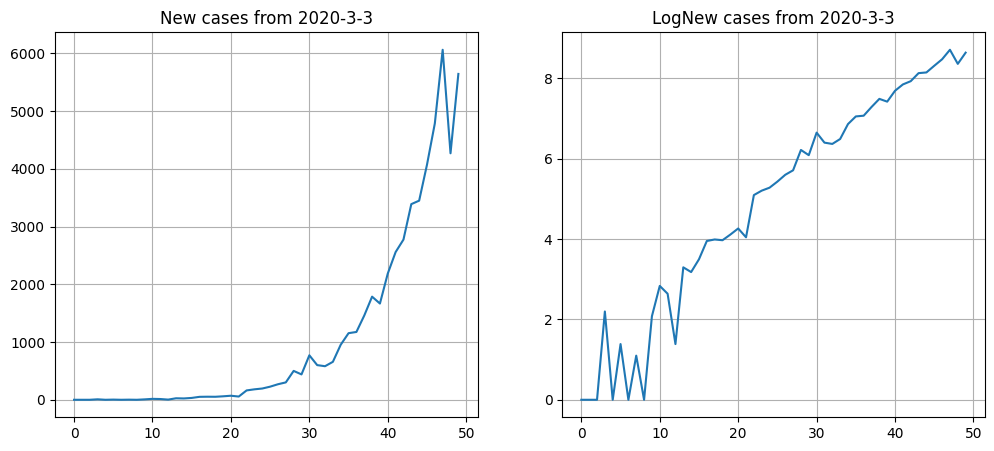

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(121)

plt.grid()
plt.plot(train_data.index, train_data["new_cases"])
plt.title("New cases from 2020-3-3")

plt.subplot(122)

plt.grid()
plt.plot(train_data.index, train_data["log_new_cases"])
plt.title("LogNew cases from 2020-3-3")
pass

# Linreg y ~ exp(x)

In [7]:
linreg = LinearRegression().fit(
    train_data.index.to_numpy().reshape(-1, 1),
    train_data["log_total_cases"].to_numpy().reshape(-1, 1)
)

In [8]:
train_prediction = linreg.predict(train_data["log_total_cases"].index.to_numpy().reshape(-1, 1))

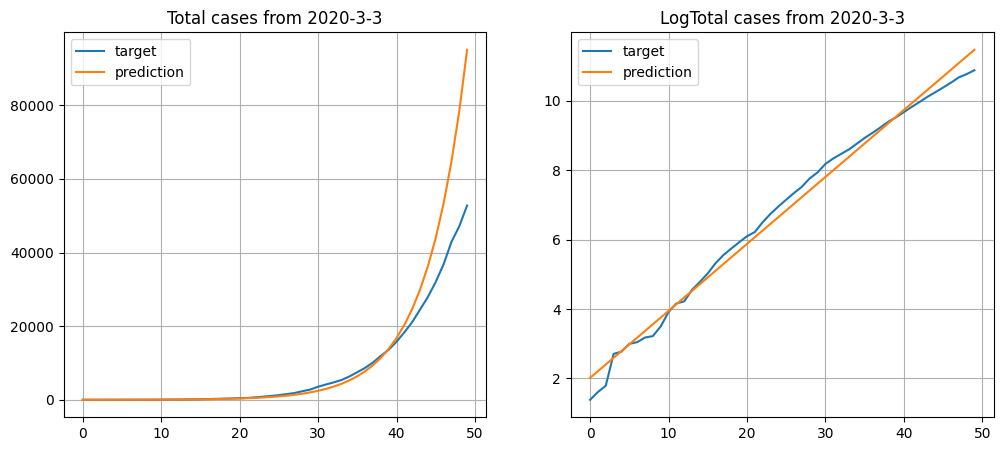

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.grid()

plt.plot(train_data.index, train_data["total_cases"], label="target")
plt.plot(train_data.index, np.exp(train_prediction), label="prediction")
plt.title("Total cases from 2020-3-3")
plt.legend()

plt.subplot(122)
plt.grid()

plt.plot(train_data.index, train_data["log_total_cases"], label="target")
plt.plot(train_data.index, train_prediction, label="prediction")
plt.title("LogTotal cases from 2020-3-3")
plt.legend()

pass

### Posterior probability

In [10]:
sigma_noise = (train_prediction - train_data["log_total_cases"].to_numpy().reshape(-1, 1)).std()
sigma_noise

0.28538314326400926

In [11]:
X = train_data.index.to_numpy().reshape(-1, 1)
X = np.hstack([np.ones_like(X), X])
y = train_data["log_total_cases"].to_numpy().reshape(-1, 1)

In [12]:
mu_prior = np.array([[0], [0]])
sigma_prior_scale = 5
sigma_prior = np.identity(2) * sigma_prior_scale

sigma_posterior = np.linalg.inv(
    np.linalg.inv(sigma_prior) + X.T @ X / sigma_noise**2    
)

mu_posterior = sigma_posterior @ (
    np.linalg.inv(sigma_prior) @ mu_prior + X.T @ y / sigma_noise**2 
)

In [13]:
sigma_posterior, mu_posterior.reshape(-1)

(array([[ 6.31585578e-03, -1.91389492e-04],
        [-1.91389492e-04,  7.81436089e-06]]),
 array([2.01407151, 0.1928458 ]))

### Sampling exponents

In [47]:
samples_num = 10

sampled_predictions = []
for _ in range(samples_num):
    sampled_w = np.random.multivariate_normal(mu_posterior.reshape(-1), sigma_posterior)
    sampled_predictions += [X @ sampled_w]


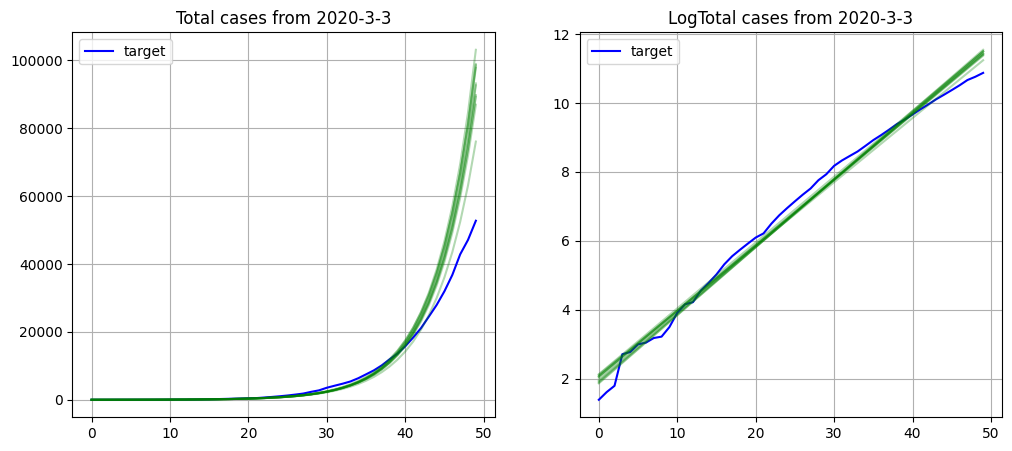

In [51]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.grid()

plt.plot(train_data.index, train_data["total_cases"], label="target", color="blue")
plt.title("Total cases from 2020-3-3")
plt.legend()

plt.subplot(122)
plt.grid()

plt.plot(train_data.index, train_data["log_total_cases"], label="target", color="blue")
plt.title("LogTotal cases from 2020-3-3")
plt.legend()


for i in range(samples_num):
    plt.subplot(121)
    plt.plot(train_data.index, np.exp(sampled_predictions[i]), color="green", alpha=0.3)


    plt.subplot(122)
    plt.plot(train_data.index, sampled_predictions[i], color="green", alpha=0.3)
    
pass

### Predicting total cases

In [62]:
new_X = np.array([
    (pd.Timestamp(2020, 5, 1) - pd.Timestamp(2020, 3, 3)).days,
    (pd.Timestamp(2020, 6, 1) - pd.Timestamp(2020, 3, 3)).days,
    (pd.Timestamp(2020, 9, 1) - pd.Timestamp(2020, 3, 3)).days
]).reshape(-1, 1)
new_X = np.hstack([np.ones_like(new_X), new_X])
new_X

array([[  1,  59],
       [  1,  90],
       [  1, 182]])

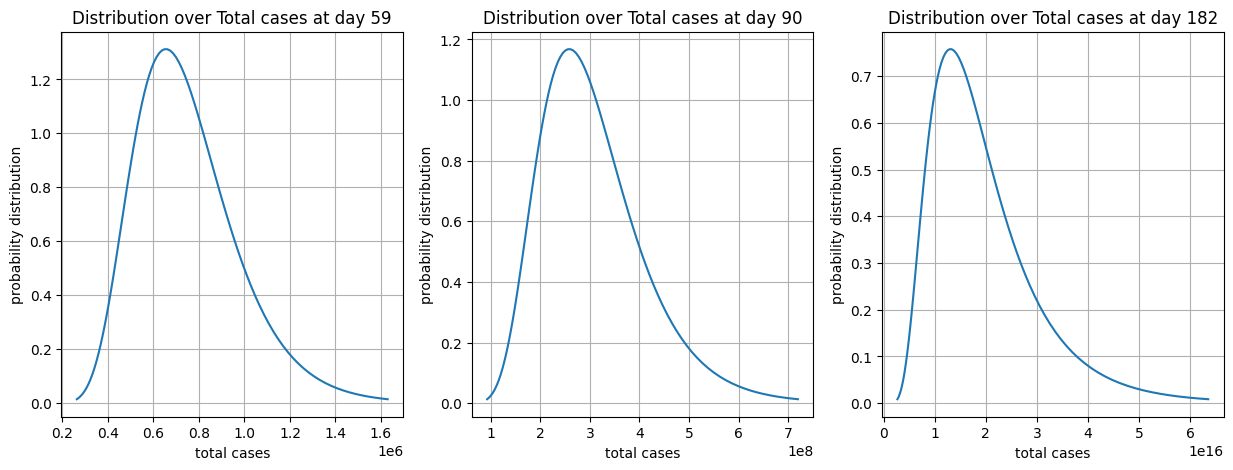

In [82]:
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=len(new_X))

for i in range(len(axes)):
    mu = mu_posterior.T @ new_X[i]
    sigma = np.sqrt(sigma_noise**2 + new_X[i].T @ sigma_posterior @ new_X[i])
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    axes[i].plot(np.exp(x), stats.norm.pdf(x, mu, sigma))
    axes[i].grid()
    axes[i].set_title(f"Distribution over Total cases at day {new_X[i][1]}")
    axes[i].set_xlabel("total cases")
    axes[i].set_ylabel("probability distribution")
    

# Linreg with Gaussian distribution function

Murray proposed sigmoid function to estimate number of sick people
$$
total\_cases = \int\limits_{-\infty}^{x} e^{w_2t^2 + w_1t + w_0} dt
$$

Taking derivative from both sides we get a great result
$$
new\_cases = e^{w_2t^2 + w_1t + w_0}
$$

$$
log(new\_cases) = w_2t^2 + w_1t + w_0
$$

And to predict total cases we just sum over new cases, estimating the integral as sum

$$
total\_cases(x) = \sum\limits_{0}^{x} e^{w_2t^2 + w_1t + w_0}
$$



In [96]:
X = train_data.index.to_numpy().reshape(-1, 1)
X = np.hstack([np.ones_like(X), X, X*X])
y = train_data["log_new_cases"].to_numpy().reshape(-1, 1)

In [97]:
poly_reg = LinearRegression().fit(X, y)
train_prediction = poly_reg.predict(X)

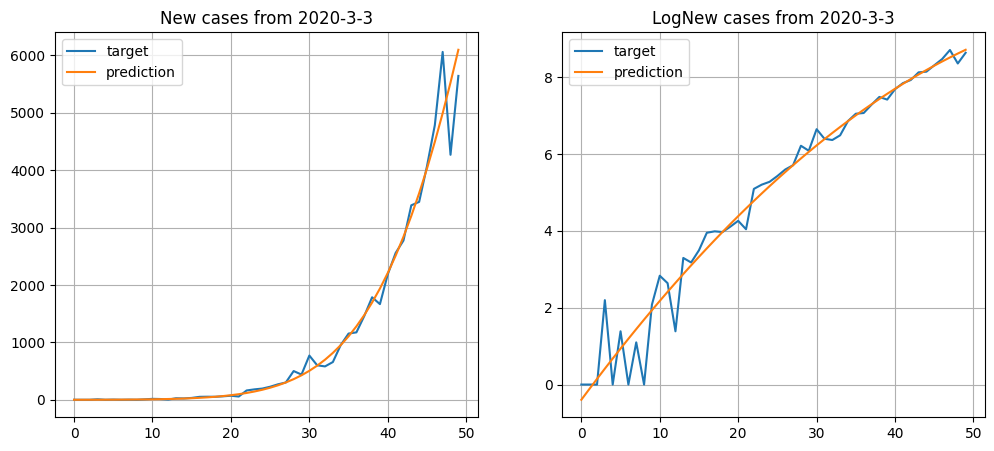

In [98]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.grid()

plt.plot(train_data.index, train_data["new_cases"], label="target")
plt.plot(train_data.index, np.exp(train_prediction), label="prediction")
plt.title("New cases from 2020-3-3")
plt.legend()

plt.subplot(122)
plt.grid()

plt.plot(train_data.index, train_data["log_new_cases"], label="target")
plt.plot(train_data.index, train_prediction, label="prediction")
plt.title("LogNew cases from 2020-3-3")
plt.legend()

pass

### Posterior probability

In [99]:
sigma_noise = (train_prediction - y).std()
sigma_noise

0.48916954245951955

In [100]:
mu_prior = np.array([[0], [0], [0]])
sigma_prior_scale = 5
sigma_prior = np.identity(3) * sigma_prior_scale

sigma_posterior = np.linalg.inv(
    np.linalg.inv(sigma_prior) + X.T @ X / sigma_noise**2    
)

mu_posterior = sigma_posterior @ (
    np.linalg.inv(sigma_prior) @ mu_prior + X.T @ y / sigma_noise**2 
)

In [102]:
mu_posterior, sigma_posterior

(array([[-0.39328262],
        [ 0.27535036],
        [-0.00182516]]),
 array([[ 3.94853693e-02, -3.19013393e-03,  5.37054491e-05],
        [-3.19013393e-03,  3.52494913e-04, -6.73214349e-06],
        [ 5.37054491e-05, -6.73214349e-06,  1.37514734e-07]]))

In [103]:
samples_num = 10

sampled_predictions = []
for _ in range(samples_num):
    sampled_w = np.random.multivariate_normal(mu_posterior.reshape(-1), sigma_posterior)
    sampled_predictions += [X @ sampled_w]


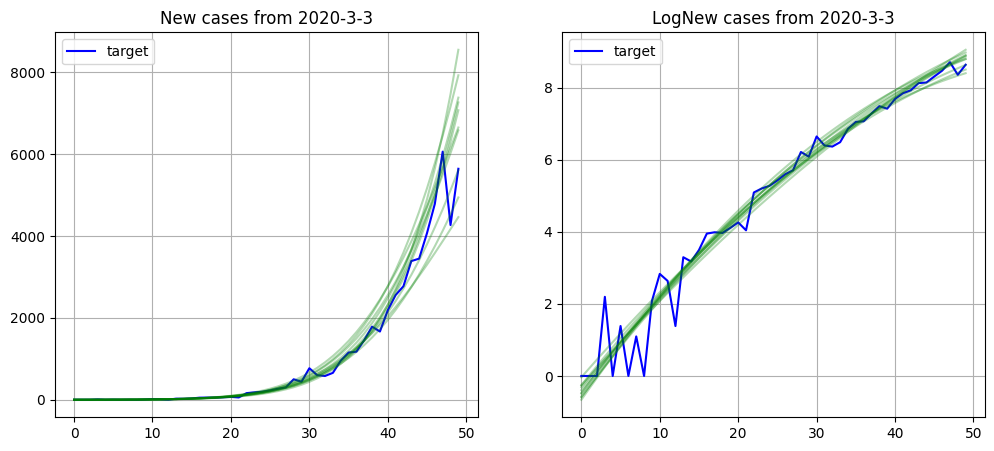

In [105]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.grid()

plt.plot(train_data.index, train_data["new_cases"], label="target", color="blue")
plt.title("New cases from 2020-3-3")
plt.legend()

plt.subplot(122)
plt.grid()

plt.plot(train_data.index, train_data["log_new_cases"], label="target", color="blue")
plt.title("LogNew cases from 2020-3-3")
plt.legend()


for i in range(samples_num):
    plt.subplot(121)
    plt.plot(train_data.index, np.exp(sampled_predictions[i]), color="green", alpha=0.3)


    plt.subplot(122)
    plt.plot(train_data.index, sampled_predictions[i], color="green", alpha=0.3)
    
pass

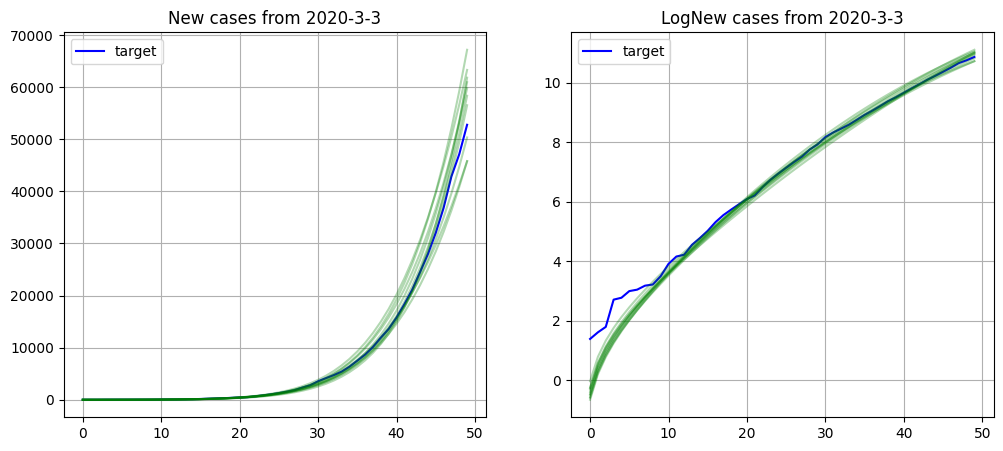

In [117]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.grid()

plt.plot(train_data.index, train_data["total_cases"], label="target", color="blue")
plt.title("New cases from 2020-3-3")
plt.legend()

plt.subplot(122)
plt.grid()

plt.plot(train_data.index, train_data["log_total_cases"], label="target", color="blue")
plt.title("LogNew cases from 2020-3-3")
plt.legend()


for i in range(samples_num):
    plt.subplot(121)
    plt.plot(train_data.index, np.exp(sampled_predictions[i]).cumsum(), color="green", alpha=0.3)


    plt.subplot(122)
    plt.plot(train_data.index, np.log(np.exp(sampled_predictions[i]).cumsum()), color="green", alpha=0.3)
    
pass

In [142]:
samples_num = 100

X = dataset.index.to_numpy().reshape(-1, 1)
X = np.hstack([np.ones_like(X), X, X*X])

sampled_predictions = []
for _ in range(samples_num):
    sampled_w = np.random.multivariate_normal(mu_posterior.reshape(-1), sigma_posterior)
    sampled_predictions += [X @ sampled_w]


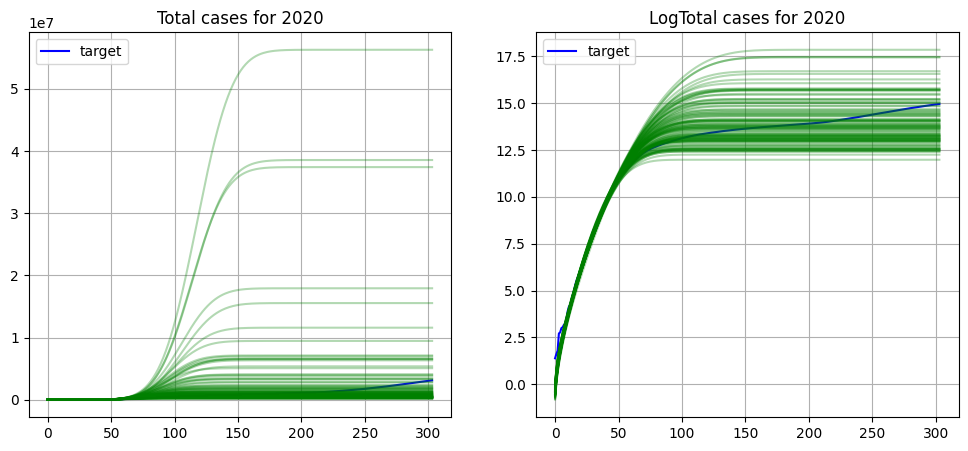

In [148]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.grid()

plt.plot(dataset.index, dataset["total_cases"], label="target", color="blue")
plt.title("Total cases for 2020")
plt.legend()

plt.subplot(122)
plt.grid()

plt.plot(dataset.index, dataset["log_total_cases"], label="target", color="blue")
plt.title("LogTotal cases for 2020")
plt.legend()


for i in range(samples_num):
    plt.subplot(121)
    plt.plot(dataset.index, np.exp(sampled_predictions[i]).cumsum(), color="green", alpha=0.3)


    plt.subplot(122)
    plt.plot(dataset.index, np.log(np.exp(sampled_predictions[i]).cumsum()), color="green", alpha=0.3)
    
pass

In [189]:
predicted_total_cases = np.exp(sampled_predictions).cumsum(axis=1)[:, -1]

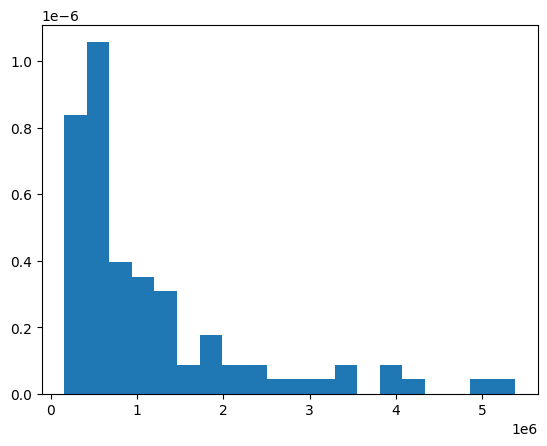

In [205]:
# Discarding outliers to get better picture
plt.hist(predicted_total_cases[predicted_total_cases < 6e6], density=True, bins=20)
pass

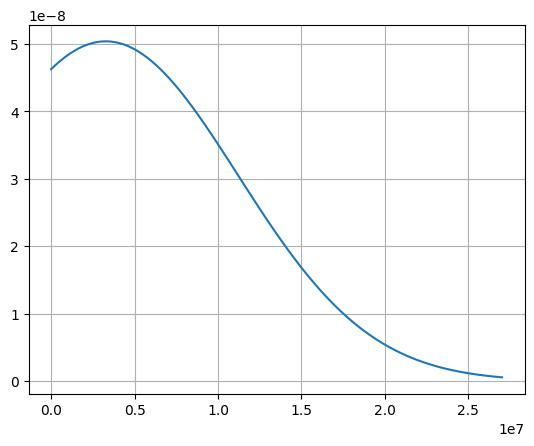

In [206]:
mu_empiric = np.mean(predicted_total_cases)
sigma_empiric = np.std(predicted_total_cases)

x = np.linspace(0, mu_empiric + 3 * sigma_empiric, 100)
plt.plot(x, stats.norm.pdf(x, mu_empiric, sigma_empiric))
plt.grid()

In [207]:
# Best case scenario
np.percentile(predicted_total_cases, 10)

289463.7994626484

In [208]:
# Worst case scenario
np.percentile(predicted_total_cases, 90)

6573586.286525027

In [209]:
# Real total cases
dataset.iloc[-1]["total_cases"]

3127352.0

As it turns out, 90th percentile is only twise as big as the number of real total cases

# My thoughts

The first thing I would like to note is that the 50th day is in the zone when the epidemic has reached saturation.

This can be seen from many graphs even before receiving data on the 50th day.

Before I realized that the derivative of total_cases is new_cases, I was trying to come up with a method for evaluating the sigmoid proposed in the task.

It seemed to me that it could be divided into 5 parts:
1. linear growth at the beginning
2. exponential growth
3. linear growth before saturation
4. exponential decrease in the growth rate
5. linear growth in saturation

Such a function will be piecewise continuous and smooth, if we take into account condition on derivatives at boundaries of continuity.

The most important parameters in such a model will be the boundaries between the parts. It seems to me that they can be estimated from successive approximations of each piece by their own formula.

I will explain by the example of the first part of the operation. We will approximate the data with a line, sequentially adding points to the data. Thus, a sequence of parameters of the linear model will be obtained. At the moment when the parameters (the angle of inclination) change dramatically (what we should count as dramatically - also a very good question), we understand that we are in a zone of 2 - exponential growth.

The resulting line will be the model obtained immediately before the critical point, and not several data samples earlier. Then, using similar logic, you can calculate the parameters for the rest of the parts.